"""
This file was created with the purpose of developing
a random forest classifier to identify market squeeze

This squeeze classification depends of the comparison of 2 indicators:
2 std of a 20 period bollinger bands and 2 atr of a 20 period keltner channel

our definition of squeeze: 
when the upper bollinger band (bbup) is less or equal to upper keltner band (kcup)
AND lower bollinger band (bblo) is above or equal to lower keltner channel (kclo)
"""


In [1]:
# Import libraries and dependencies
import pandas as pd
import numpy as np
from pathlib import Path
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
csv_path = Path('../Resources/ts_squeeze_jpm.csv')
csv_path

WindowsPath('../Resources/ts_squeeze_jpm.csv')

In [3]:
ts_file_df = pd.read_csv(csv_path, parse_dates=[['Date', 'Time']])
ts_file_df.tail()

,Date_Time,Open,High,Low,Close,Up,Down,kcup,kclo,MidLine,bbup,bblo,MidLine.1,FastEMA,SlowEMA,squeeze
19574,2021-01-11 14:00:00,137.67,137.92,137.65,137.86,211198,218904,137.68,136.12,136.90,138.25,135.54,136.90,137.50,136.97,0
19575,2021-01-11 14:15:00,137.87,138.20,137.79,137.87,269373,269716,137.71,136.20,136.95,138.37,135.54,136.95,137.58,137.05,0
19576,2021-01-11 14:30:00,137.87,137.99,137.56,137.89,194671,253946,137.76,136.30,137.03,138.48,135.59,137.03,137.64,137.13,0
19577,2021-01-11 14:45:00,137.89,138.03,137.57,137.74,220389,320640,137.85,136.37,137.11,138.53,135.70,137.11,137.66,137.18,0
19578,2021-01-11 15:00:00,137.75,138.16,137.75,138.11,718139,697851,137.96,136.45,137.21,138.62,135.79,137.21,137.75,137.27,0


In [4]:
# set index as Date_Time and drop MidLine.1 column (it is a duplicate of MidLine)
ts_file_df.set_index(pd.to_datetime(ts_file_df['Date_Time'], infer_datetime_format=True), inplace=True)
ts_file_df.drop(columns=['Date_Time', 'MidLine.1'], inplace=True)
ts_file_df.head()

,Open,High,Low,Close,Up,Down,kcup,kclo,MidLine,bbup,bblo,FastEMA,SlowEMA,squeeze
Date_Time,,,,,,,,,,,,,,
2018-01-12 08:45:00,111.65,111.98,110.84,111.22,1051611,1206429,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0
2018-01-12 09:00:00,111.21,112.04,111.17,111.93,645133,604771,0.0,0.0,0.0,0.0,0.0,111.93,111.93,0
2018-01-12 09:15:00,111.93,112.20,111.87,112.13,541130,492175,0.0,0.0,0.0,0.0,0.0,111.97,111.95,0
2018-01-12 09:30:00,112.13,112.18,111.56,111.91,332412,418068,0.0,0.0,0.0,0.0,0.0,111.96,111.94,0
2018-01-12 09:45:00,111.91,112.24,111.85,111.97,281205,290538,0.0,0.0,0.0,0.0,0.0,111.96,111.95,0


In [5]:
# Set a variable list of features to feed to our model

x_var_list = ['Open', 'High', 'Low', 'Close', 'Up', 'Down', 'kcup', 'kclo', 'MidLine', 'bbup', 'bblo', 'FastEMA', 'SlowEMA']
ts_file_df[x_var_list].head()

,Open,High,Low,Close,Up,Down,kcup,kclo,MidLine,bbup,bblo,FastEMA,SlowEMA
Date_Time,,,,,,,,,,,,,
2018-01-12 08:45:00,111.65,111.98,110.84,111.22,1051611,1206429,0.0,0.0,0.0,0.0,0.0,0.00,0.00
2018-01-12 09:00:00,111.21,112.04,111.17,111.93,645133,604771,0.0,0.0,0.0,0.0,0.0,111.93,111.93
2018-01-12 09:15:00,111.93,112.20,111.87,112.13,541130,492175,0.0,0.0,0.0,0.0,0.0,111.97,111.95
2018-01-12 09:30:00,112.13,112.18,111.56,111.91,332412,418068,0.0,0.0,0.0,0.0,0.0,111.96,111.94
2018-01-12 09:45:00,111.91,112.24,111.85,111.97,281205,290538,0.0,0.0,0.0,0.0,0.0,111.96,111.95


In [6]:
# Shift DataFrame values by 1
ts_file_df[x_var_list] = ts_file_df[x_var_list].shift(1)
ts_file_df[x_var_list].head()

,Open,High,Low,Close,Up,Down,kcup,kclo,MidLine,bbup,bblo,FastEMA,SlowEMA
Date_Time,,,,,,,,,,,,,
2018-01-12 08:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-12 09:00:00,111.65,111.98,110.84,111.22,1051611.0,1206429.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00
2018-01-12 09:15:00,111.21,112.04,111.17,111.93,645133.0,604771.0,0.0,0.0,0.0,0.0,0.0,111.93,111.93
2018-01-12 09:30:00,111.93,112.20,111.87,112.13,541130.0,492175.0,0.0,0.0,0.0,0.0,0.0,111.97,111.95
2018-01-12 09:45:00,112.13,112.18,111.56,111.91,332412.0,418068.0,0.0,0.0,0.0,0.0,0.0,111.96,111.94


In [7]:
ts_file_df.dropna(inplace=True)
ts_file_df.head()

,Open,High,Low,Close,Up,Down,kcup,kclo,MidLine,bbup,bblo,FastEMA,SlowEMA,squeeze
Date_Time,,,,,,,,,,,,,,
2018-01-12 09:00:00,111.65,111.98,110.84,111.22,1051611.0,1206429.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0
2018-01-12 09:15:00,111.21,112.04,111.17,111.93,645133.0,604771.0,0.0,0.0,0.0,0.0,0.0,111.93,111.93,0
2018-01-12 09:30:00,111.93,112.20,111.87,112.13,541130.0,492175.0,0.0,0.0,0.0,0.0,0.0,111.97,111.95,0
2018-01-12 09:45:00,112.13,112.18,111.56,111.91,332412.0,418068.0,0.0,0.0,0.0,0.0,0.0,111.96,111.94,0
2018-01-12 10:00:00,111.91,112.24,111.85,111.97,281205.0,290538.0,0.0,0.0,0.0,0.0,0.0,111.96,111.95,0


In [8]:
# Construct training start and training end dates

training_start = ts_file_df.index.min().strftime(format='%Y-%m-%d')
training_end = '2019-01-11'

# Construct test start and test end dates

testing_start = '2019-01-12'
testing_end = '2019-06-12'

# Construct validating start and validating end dates

vali_start = '2019-06-13'
vali_end = '2020-01-12'

# Confirming training, testing and validating dates
print(f"Training Start: {training_start}")
print(f"Training End: {training_end}")
print(f"Testing Start: {testing_start}")
print(f"Testing End: {testing_end}")
print(f"validating Start: {vali_start}")
print(f"validating end: {vali_end}")

Training Start: 2018-01-12
Training End: 2019-01-11
Testing Start: 2019-01-12
Testing End: 2019-06-12
validating Start: 2019-06-13
validating end: 2020-01-12


In [9]:
# Construct the X_train and y_train datasets
X_train = ts_file_df[x_var_list][training_start:training_end]
y_train = ts_file_df['squeeze'][training_start:training_end]

# Construct the X test and y test datasets

X_test = ts_file_df[x_var_list][testing_start:testing_end]
y_test = ts_file_df['squeeze'][testing_start:testing_end]

X_test.head()

,Open,High,Low,Close,Up,Down,kcup,kclo,MidLine,bbup,bblo,FastEMA,SlowEMA
Date_Time,,,,,,,,,,,,,
2019-01-14 08:45:00,100.09,100.16,99.88,99.93,538000.0,839750.0,100.32,99.54,99.93,100.22,99.64,99.99,99.95
2019-01-14 09:00:00,98.85,100.07,98.66,100.00,662220.0,467174.0,100.45,99.47,99.96,100.14,99.78,99.99,99.96
2019-01-14 09:15:00,99.98,100.22,99.73,100.14,315701.0,326009.0,100.50,99.47,99.98,100.12,99.85,100.02,99.97
2019-01-14 09:30:00,100.15,100.94,100.08,100.88,338536.0,318028.0,100.61,99.46,100.04,100.44,99.63,100.19,100.06
2019-01-14 09:45:00,100.88,101.01,100.43,100.68,328545.0,363630.0,100.68,99.46,100.07,100.56,99.58,100.29,100.11


In [10]:
y_test.head()

Date_Time
2019-01-14 08:45:00    1
2019-01-14 09:00:00    1
2019-01-14 09:15:00    1
2019-01-14 09:30:00    1
2019-01-14 09:45:00    1
Name: squeeze, dtype: int64

In [11]:
# Construct the X valid and y validation datasets

X_vali = ts_file_df[x_var_list][vali_start:vali_end]
y_vali = ts_file_df['squeeze'][vali_start:vali_end]

X_vali.head()

,Open,High,Low,Close,Up,Down,kcup,kclo,MidLine,bbup,bblo,FastEMA,SlowEMA
Date_Time,,,,,,,,,,,,,
2019-06-13 08:45:00,109.01,109.30,109.00,109.27,475047.0,353967.0,109.66,108.71,109.18,109.44,108.92,109.19,109.36
2019-06-13 09:00:00,109.46,110.09,109.39,110.06,182719.0,288328.0,109.74,108.69,109.22,109.67,108.76,109.37,109.42
2019-06-13 09:15:00,110.07,110.16,109.69,109.85,179614.0,123755.0,109.79,108.69,109.24,109.76,108.71,109.46,109.46
2019-06-13 09:30:00,109.85,109.99,109.43,109.43,158128.0,180381.0,109.81,108.69,109.25,109.78,108.72,109.46,109.46
2019-06-13 09:45:00,109.43,109.56,109.32,109.46,94904.0,99241.0,109.83,108.72,109.28,109.79,108.76,109.46,109.46


In [12]:
y_vali.tail()

Date_Time
2020-01-10 14:00:00    0
2020-01-10 14:15:00    0
2020-01-10 14:30:00    0
2020-01-10 14:45:00    0
2020-01-10 15:00:00    0
Name: squeeze, dtype: int64

In [13]:
# StandardScaler 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [14]:
# Creating the StandardScaler instant 
scaler = StandardScaler()

In [15]:
# Feeding StandardScaler for X_train, X_test, X_vali
X_scaler_train = scaler.fit(X_train)

In [16]:
# Scaling the data 
X_train_scaled = X_scaler_train.transform(X_train)

In [17]:
X_test_scaled = X_scaler_train.transform(X_test)

In [18]:
X_vali_scaled = X_scaler_train.transform(X_vali)

In [19]:
# Import SKLearn library and Classes
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [81]:
# Fit SKLearn regression with training datasets:
model = RandomForestClassifier(n_estimators=1000, max_depth=25, random_state=1)
model.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=25, n_estimators=1000, random_state=1)

In [82]:
# Make predictions of "y" values from the X_test dataset
predictions = model.predict(X_test_scaled)

In [83]:
# Assemble actual y_test with predicted values

compare_predict_df = y_test.to_frame()
compare_predict_df["predict_emax"] = predictions

compare_predict_df

,squeeze,predict_emax
Date_Time,,
2019-01-14 08:45:00,1,1
2019-01-14 09:00:00,1,1
2019-01-14 09:15:00,1,1
2019-01-14 09:30:00,1,1
2019-01-14 09:45:00,1,1
...,...,...
2019-06-12 14:00:00,0,1
2019-06-12 14:15:00,1,1
2019-06-12 14:30:00,1,1


In [84]:
# Save the pre-trained model
from joblib import dump, load
dump(model, 'random_forest_model_scaled_squeeze.joblib')

['random_forest_model_scaled_squeeze.joblib']

In [85]:
X_test_scaled

array([[-2.01018876, -2.04341379, -2.00056841, ..., -1.197015  ,
        -1.96863025, -1.99151259],
       [-2.24842935, -2.06080352, -2.23350288, ..., -1.17966479,
        -1.96863025, -1.98963356],
       [-2.03132301, -2.03182064, -2.0292079 , ..., -1.17098968,
        -1.96303096, -1.98775453],
       ...,
       [-0.22914823, -0.26000076, -0.21919249, ..., -0.0593366 ,
        -0.24404895, -0.21019244],
       [-0.24836118, -0.28318706, -0.24592268, ..., -0.0580973 ,
        -0.24778181, -0.21582953],
       [-0.27141672, -0.29671241, -0.25928777, ..., -0.05314009,
        -0.25524753, -0.22146662]])

In [86]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm)

In [87]:
cm_df

,0,1
0,1002,494
1,316,892


In [88]:
# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)
acc_score

0.7004437869822485

In [89]:
# Display results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score {acc_score}")
print(classification_report(y_test, predictions))

Confusion Matrix


,0,1
0,1002,494
1,316,892


Accuracy Score 0.7004437869822485
              precision    recall  f1-score   support

           0       0.76      0.67      0.71      1496
           1       0.64      0.74      0.69      1208

    accuracy                           0.70      2704
   macro avg       0.70      0.70      0.70      2704
weighted avg       0.71      0.70      0.70      2704



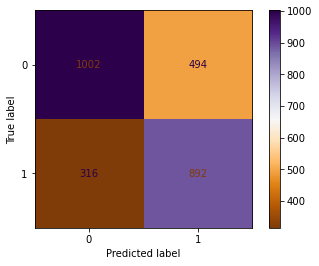

In [90]:
from sklearn.metrics import ConfusionMatrixDisplay
cm_display = ConfusionMatrixDisplay(cm).plot(cmap='PuOr')